#### Benchmaking Experiment 006b
- benchmarking model architecture -3 with PAMAP2, DaLiAc and UTD-MHAD datasets
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader, DaLiAcReader, UTDReader
from src.datasets.dataset import PAMAP2Dataset, DaLiAcDataset, UTDDataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
# from src.running import train_step1, eval_step1

In [7]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "UTD", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

---

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
def train_step1(model, dataloader, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())
                feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [6]:
def eval_step1(model, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())
                feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = np.argmax(action_probs, axis=1)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

---

In [8]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
elif dt == 'DaLiAc':
    dataReader = DaLiAcReader('./data/DaLiAc_Dataset/')
elif dt == 'UTD':
    dataReader = UTDReader('./data/UTD-MHAD-Inertial/')
actionList = dataReader.idToLabel

1


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:298: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), np.array(labels, dtype=int), np.array(subjects)


In [9]:
dataReader.data.shape

(124,)

In [10]:
# import PAMAP2 attributes
if dt == 'PAMAP2':   
    fpath = './data/PAMAP2_Dataset/PAMAP2_attributes.json'
elif dt == 'DaLiAc':
    fpath = './data/DaLiAc_Dataset/DaLiAc_attributes.json'
elif dt == 'UTD':
    fpath = './data/UTD-MHAD-Inertial/UTD_attributes.json'

activity_dict, attribute_dict, attr_mat = load_attribute(fpath)
_, attr_size = attr_mat.shape

In [11]:
# Load semantic feature space 
st = config['sem-space']
if dt == 'PAMAP2':
    if st == 'glove50-v1':
        fpath = './data/PAMAP2_Dataset/glove_features.npy'
    elif st == 'glove50-v2':
        fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
    elif st == 'video-V1':
        fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
    elif st == 'word2vec-v1':
        fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
    elif st == 'word2vec-v2':
        fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'
    elif st == 'attr':
        fpath = './data/PAMAP2_Dataset/attribute_ft.npy'
elif dt == 'DaLiAc':
    if st == 'glove50-v1':
        pass 
    elif st == 'attr':
        fpath = './data/DaLiAc_Dataset/attribute_ft.npy'
elif dt == 'UTD':
    if st == 'glove50-v1':
        pass 
    elif st == 'attr':
        fpath = './data/UTD-MHAD-Inertial/attribute_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [12]:
# run 5-fold running
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]
elif dt == 'DaLiAc':
    fold_classes = [['sitting', 'vacuuming', 'descending stairs'], ['lying', 'sweeping', 'treadmill running'], ['standing', 'walking', 'cycling'], ['washing dishes', 'ascending stairs', 'rope jumping']]
elif dt == 'UTD':
    fold_classes = [['swipe left', 'cross arms', 'draw triangle', 'arm curl', 'jogging in place', 'pick up then throw'], ['swipe right', 'basketball shoot', 'bowling', 'tennis serve', 'walking in place', 'squat'], ['wave', 'draw x', 'boxing', 'two hand push', 'sit to stand'], ['clap', 'draw circle clockwise', 'baseball swing', 'knock', 'stand to sit'], ['throw', 'draw circle counter clockwise', 'tennis swing', 'catch', 'lunge']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [13]:
if config['dataset'] == 'PAMAP2':
    dts = PAMAP2Dataset
elif config['dataset'] == 'DaLiAc':
    dts = DaLiAcDataset
elif config['dataset'] == 'UTD':
    dts = UTDDataset

In [14]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = dts(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape)
    break

torch.Size([32, 105, 27])


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


seen: 100%|██████████| 130/130 [00:05<00:00, 25.32batch/s, loss=0.208]


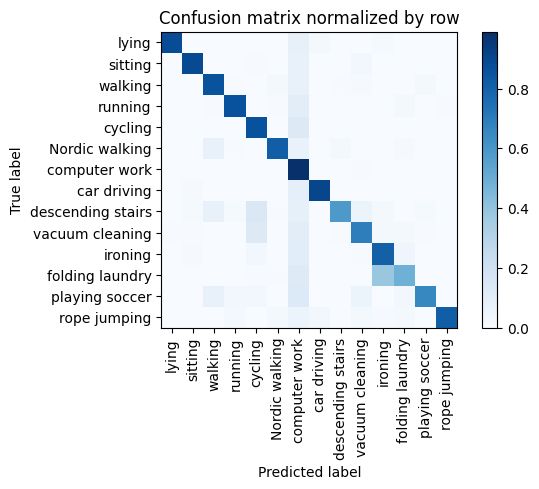

Training Epoch:  10%|█         | 1/10 [00:36<05:30, 36.69s/it]

Overall accuracy: 0.829



seen: 100%|██████████| 130/130 [00:04<00:00, 28.07batch/s, loss=0.668]


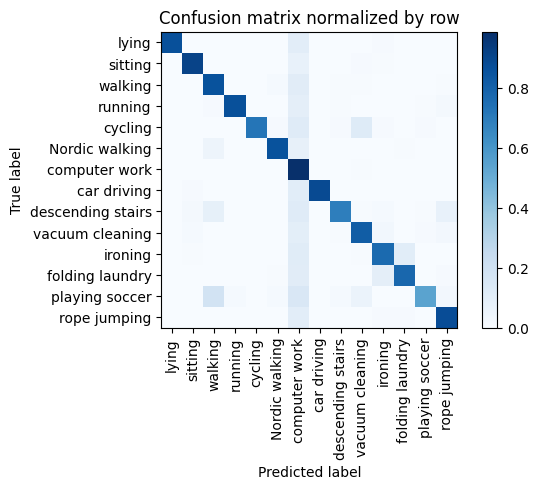

Training Epoch:  20%|██        | 2/10 [01:06<04:22, 32.85s/it]

Overall accuracy: 0.844



seen: 100%|██████████| 130/130 [00:03<00:00, 40.05batch/s, loss=0.257]


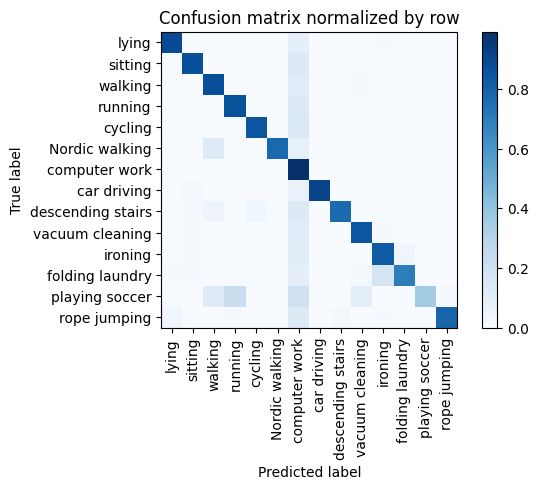

Training Epoch:  30%|███       | 3/10 [01:28<03:14, 27.85s/it]

Overall accuracy: 0.850



seen: 100%|██████████| 130/130 [00:03<00:00, 40.79batch/s, loss=0.411]


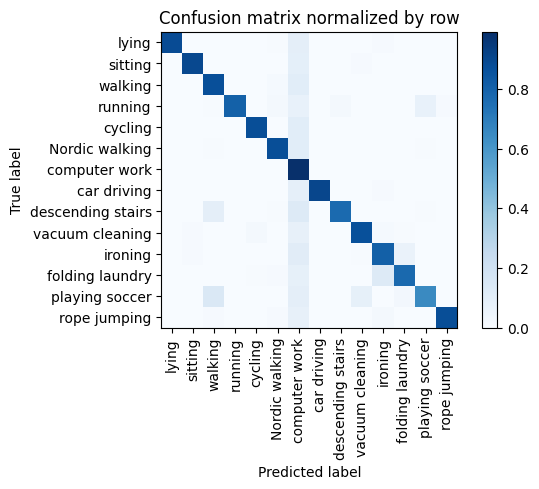

Training Epoch:  40%|████      | 4/10 [01:47<02:26, 24.33s/it]

Overall accuracy: 0.872



seen: 100%|██████████| 130/130 [00:02<00:00, 45.89batch/s, loss=0.124]


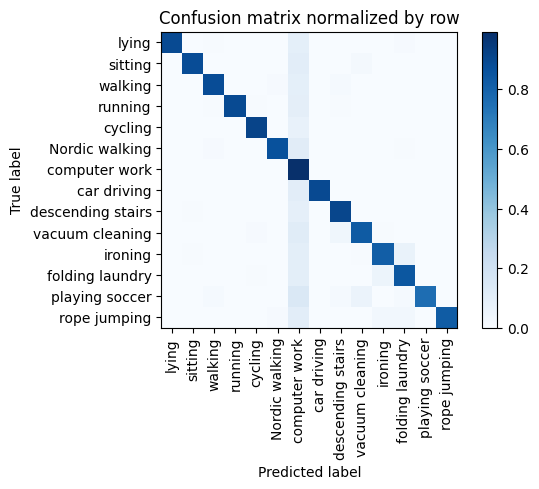

Training Epoch:  50%|█████     | 5/10 [02:08<01:55, 23.07s/it]

Overall accuracy: 0.886



seen: 100%|██████████| 130/130 [00:03<00:00, 40.37batch/s, loss=0.291]


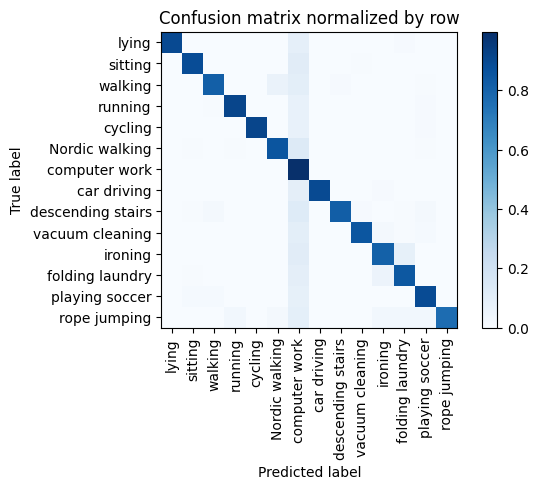

Training Epoch:  60%|██████    | 6/10 [02:28<01:27, 21.96s/it]

Overall accuracy: 0.877



seen: 100%|██████████| 130/130 [00:03<00:00, 40.19batch/s, loss=0.374]


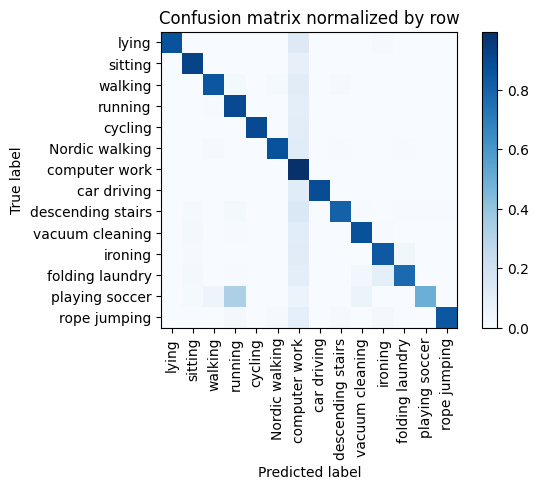

Training Epoch:  70%|███████   | 7/10 [02:47<01:03, 21.08s/it]

Overall accuracy: 0.874



seen: 100%|██████████| 130/130 [00:03<00:00, 33.48batch/s, loss=0.335]


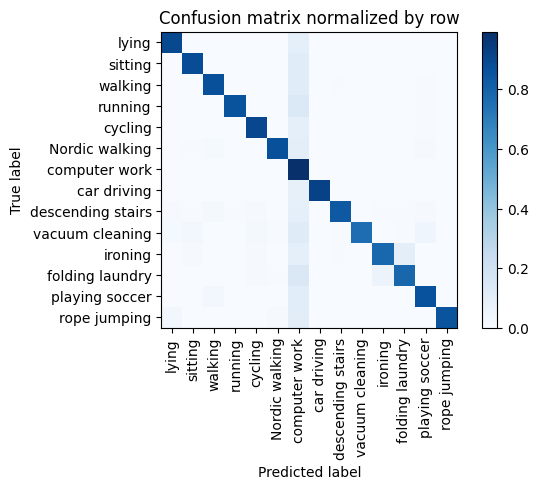

Training Epoch:  80%|████████  | 8/10 [03:08<00:41, 20.88s/it]

Overall accuracy: 0.871



seen: 100%|██████████| 130/130 [00:03<00:00, 35.83batch/s, loss=0.182]


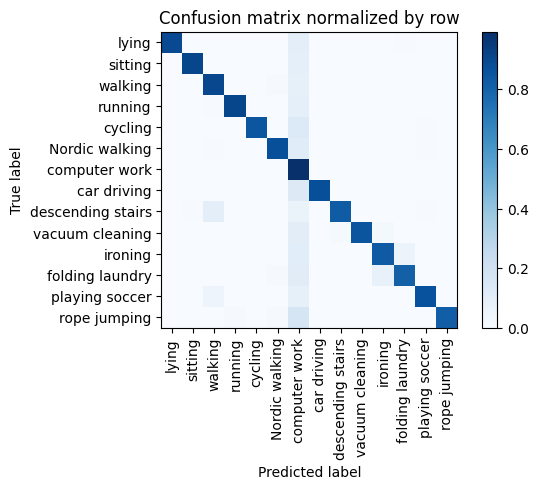

Training Epoch:  90%|█████████ | 9/10 [03:36<00:23, 23.28s/it]

Overall accuracy: 0.887



seen: 100%|██████████| 130/130 [00:03<00:00, 40.73batch/s, loss=0.682]


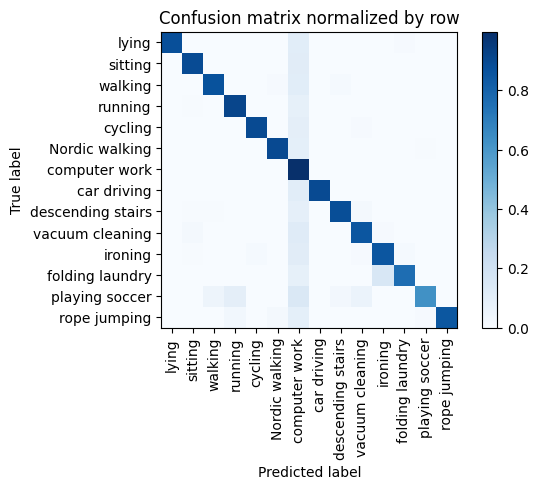

Overall accuracy: 0.884



unseen: 100%|██████████| 175/175 [00:02<00:00, 63.98batch/s, loss=7.88]


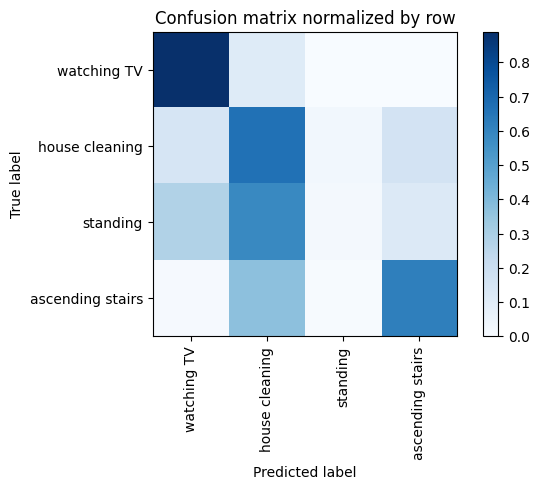

Overall accuracy: 0.475

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.375      0.016      0.031      0.331       1851|	 house cleaning: 0.584,	watching TV: 0.280,	ascending stairs: 0.120,	
  house cleaning       0.438      0.665      0.528      0.329       1840|	 ascending stairs: 0.162,	watching TV: 0.148,	
ascending stairs       0.561      0.618      0.588      0.193       1079|	 house cleaning: 0.369,	watching TV: 0.009,	
     watching TV       0.480      0.889      0.623      0.148        830|	 house cleaning: 0.110,	ascending stairs: 0.001,	

----------------------------------------------------------------------------------------------------
     avg / total       0.447      0.475      0.389        1.0       5600|	      

{'total_accuracy': 0.47464285714285714, 'precision': 0.4634650976286314, 'recall': 0.5470507406353895, 'f1': 0.4426285525312722}
================ Fold-1 ================
Unseen Classes : ['wa

seen: 100%|██████████| 131/131 [00:02<00:00, 49.17batch/s, loss=0.681]


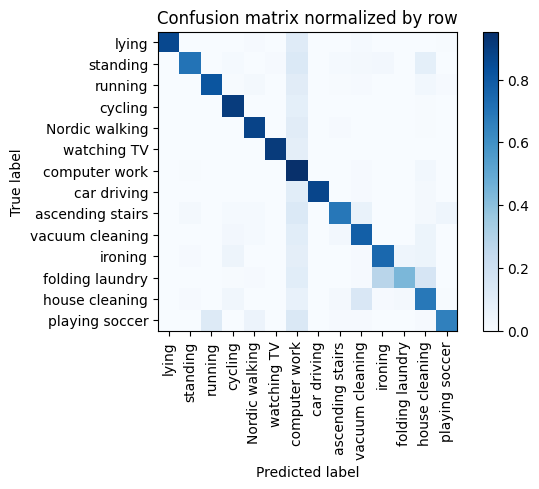

Training Epoch:  10%|█         | 1/10 [00:19<02:58, 19.81s/it]

Overall accuracy: 0.798



seen: 100%|██████████| 131/131 [00:03<00:00, 41.39batch/s, loss=0.304]


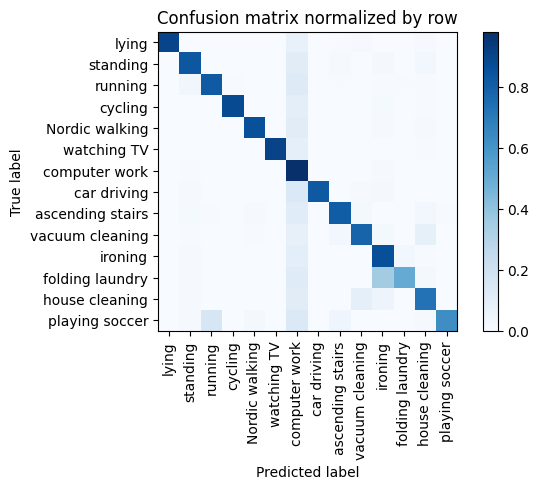

Training Epoch:  20%|██        | 2/10 [00:38<02:31, 18.92s/it]

Overall accuracy: 0.837



seen: 100%|██████████| 131/131 [00:02<00:00, 45.07batch/s, loss=0.668]


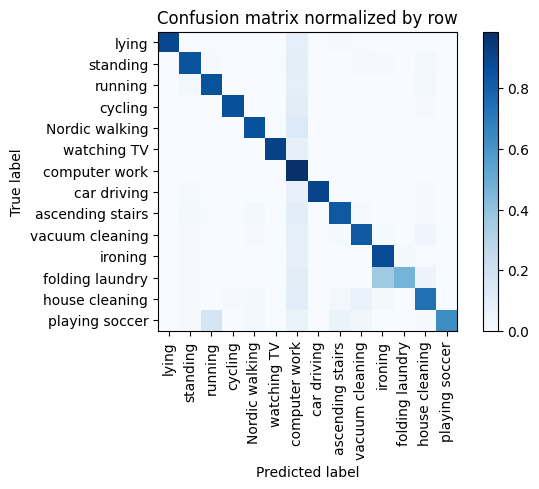

Training Epoch:  30%|███       | 3/10 [00:56<02:10, 18.68s/it]

Overall accuracy: 0.848



seen: 100%|██████████| 131/131 [00:03<00:00, 39.72batch/s, loss=0.283]


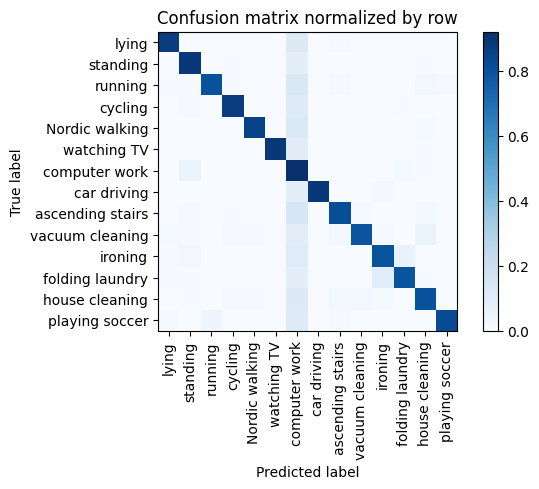

Training Epoch:  40%|████      | 4/10 [01:19<02:01, 20.26s/it]

Overall accuracy: 0.848



seen: 100%|██████████| 131/131 [00:03<00:00, 38.83batch/s, loss=0.633]


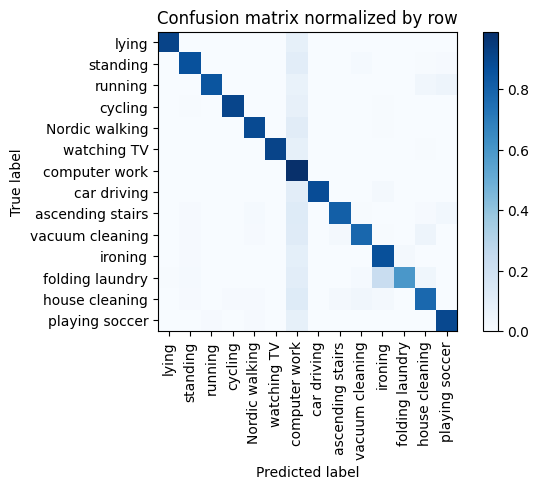

Training Epoch:  50%|█████     | 5/10 [01:39<01:42, 20.46s/it]

Overall accuracy: 0.864



seen: 100%|██████████| 131/131 [00:04<00:00, 28.02batch/s, loss=0.458]


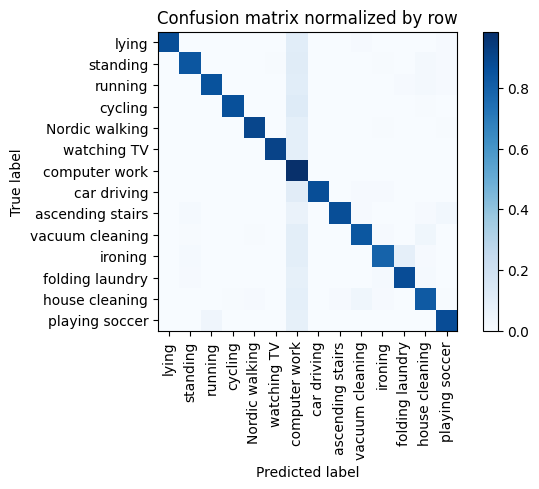

Training Epoch:  60%|██████    | 6/10 [02:11<01:37, 24.31s/it]

Overall accuracy: 0.871



seen: 100%|██████████| 131/131 [00:03<00:00, 43.12batch/s, loss=0.395]


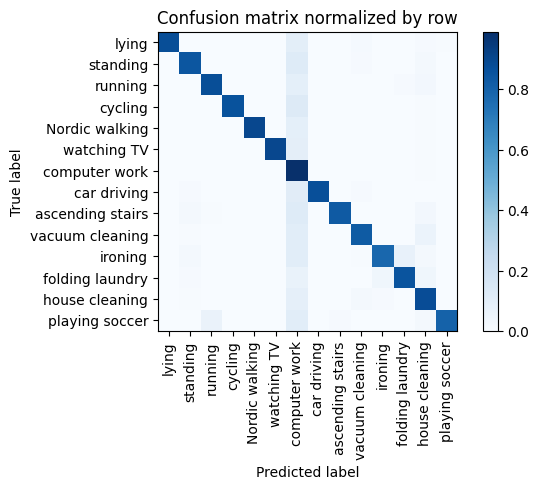

Training Epoch:  70%|███████   | 7/10 [02:31<01:08, 22.96s/it]

Overall accuracy: 0.870



seen: 100%|██████████| 131/131 [00:02<00:00, 44.43batch/s, loss=0.329]


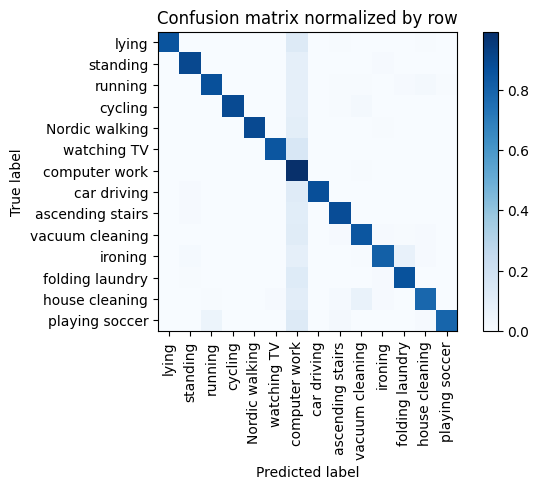

Training Epoch:  80%|████████  | 8/10 [02:51<00:43, 21.86s/it]

Overall accuracy: 0.872



seen: 100%|██████████| 131/131 [00:03<00:00, 36.77batch/s, loss=0.346]


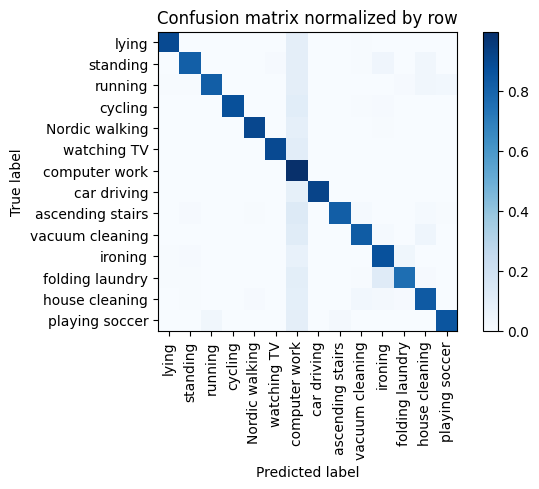

Training Epoch:  90%|█████████ | 9/10 [03:13<00:21, 21.79s/it]

Overall accuracy: 0.874



seen: 100%|██████████| 131/131 [00:03<00:00, 41.45batch/s, loss=0.3]


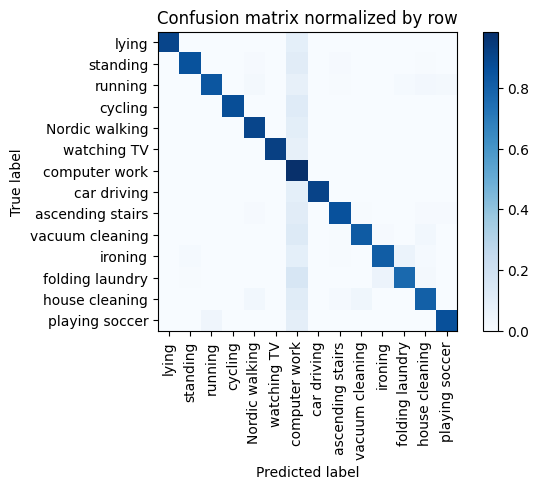

Overall accuracy: 0.870



unseen: 100%|██████████| 173/173 [00:02<00:00, 60.62batch/s, loss=9.39]


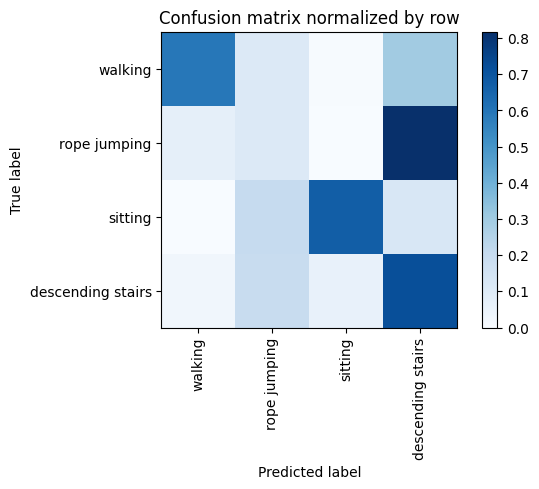

Overall accuracy: 0.600

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.958      0.591      0.731      0.421       2330|	 descending stairs: 0.295,	rope jumping: 0.109,	
          sitting       0.947      0.673      0.786      0.324       1796|	 rope jumping: 0.202,	descending stairs: 0.125,	
descending stairs       0.347      0.720      0.468      0.172        950|	 rope jumping: 0.192,	sitting: 0.060,	
     rope jumping       0.060      0.111      0.078      0.083        460|	 descending stairs: 0.817,	walking: 0.072,	

----------------------------------------------------------------------------------------------------
      avg / total       0.775      0.600      0.650        1.0       5536|	      

{'total_accuracy': 0.5998916184971098, 'precision': 0.5778374696069517, 'recall': 0.5237229162190367, 'f1': 0.5159705335158427}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'v

seen: 100%|██████████| 121/121 [00:01<00:00, 79.20batch/s, loss=0.758]


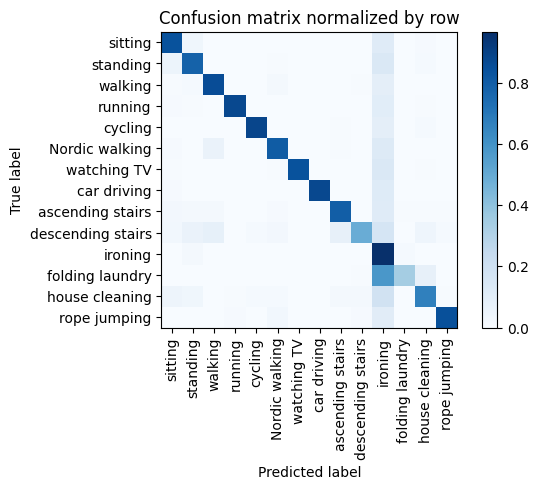

Training Epoch:  10%|█         | 1/10 [00:11<01:43, 11.50s/it]

Overall accuracy: 0.790



seen: 100%|██████████| 121/121 [00:01<00:00, 77.15batch/s, loss=0.362]


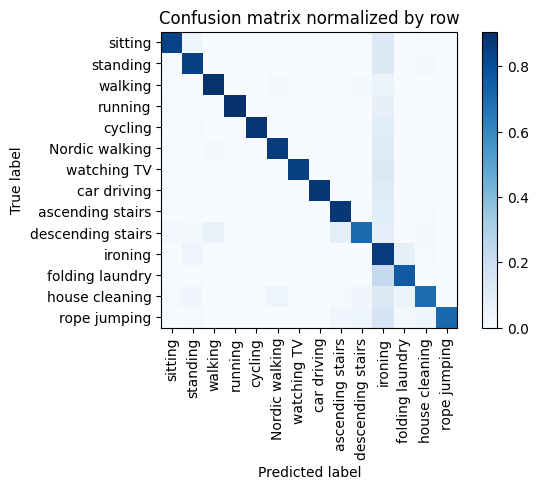

Training Epoch:  20%|██        | 2/10 [00:22<01:29, 11.24s/it]

Overall accuracy: 0.834



seen: 100%|██████████| 121/121 [00:01<00:00, 76.42batch/s, loss=0.424]


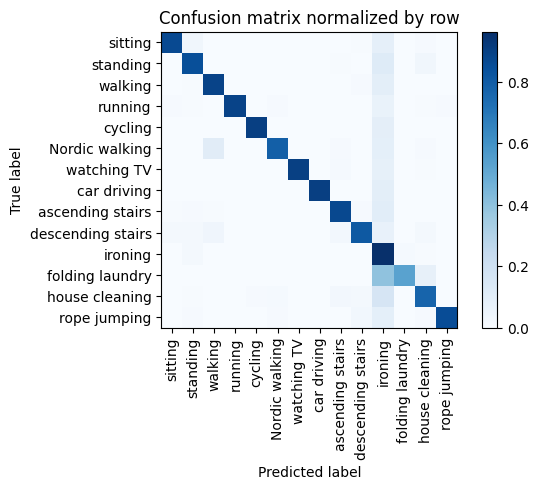

Training Epoch:  30%|███       | 3/10 [00:33<01:16, 10.94s/it]

Overall accuracy: 0.848



seen: 100%|██████████| 121/121 [00:01<00:00, 78.10batch/s, loss=0.395]


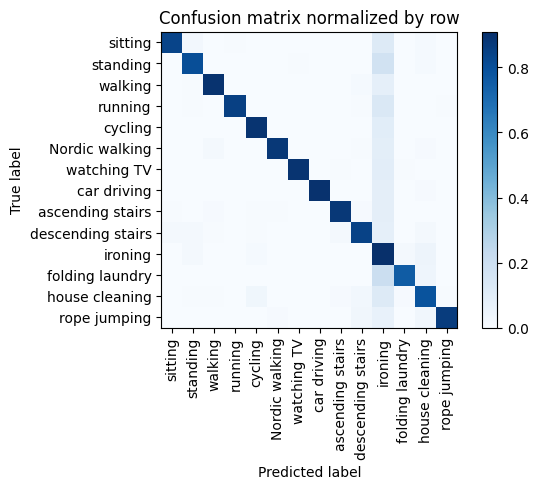

Training Epoch:  40%|████      | 4/10 [00:43<01:04, 10.74s/it]

Overall accuracy: 0.858



seen: 100%|██████████| 121/121 [00:01<00:00, 80.62batch/s, loss=0.235]


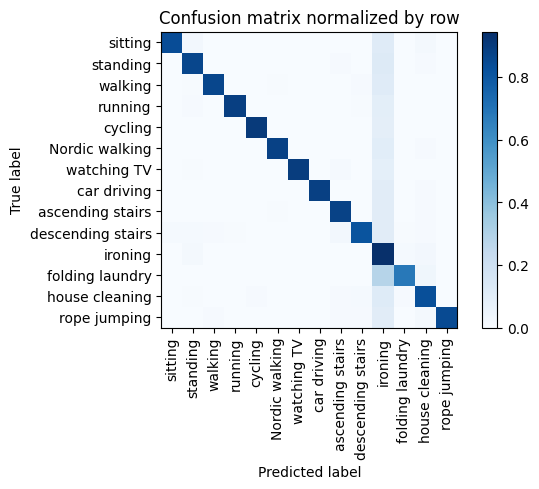

Training Epoch:  50%|█████     | 5/10 [00:53<00:53, 10.62s/it]

Overall accuracy: 0.865



seen: 100%|██████████| 121/121 [00:03<00:00, 38.23batch/s, loss=0.525]


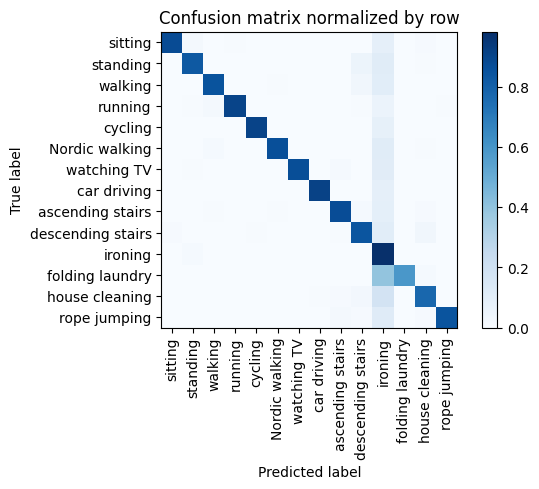

Training Epoch:  60%|██████    | 6/10 [01:12<00:53, 13.44s/it]

Overall accuracy: 0.859



seen: 100%|██████████| 121/121 [00:02<00:00, 44.71batch/s, loss=0.436]


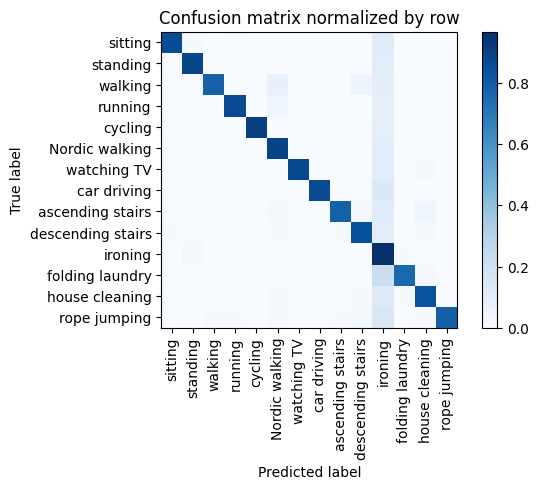

Training Epoch:  70%|███████   | 7/10 [01:32<00:46, 15.55s/it]

Overall accuracy: 0.861



seen: 100%|██████████| 121/121 [00:02<00:00, 43.53batch/s, loss=0.244]


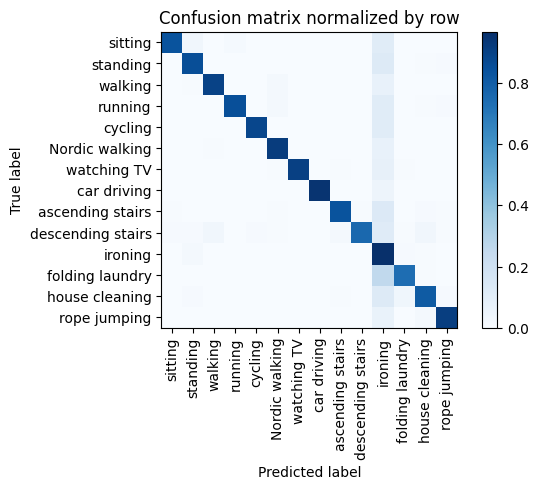

Training Epoch:  80%|████████  | 8/10 [01:50<00:32, 16.27s/it]

Overall accuracy: 0.871



seen: 100%|██████████| 121/121 [00:02<00:00, 45.38batch/s, loss=0.235]


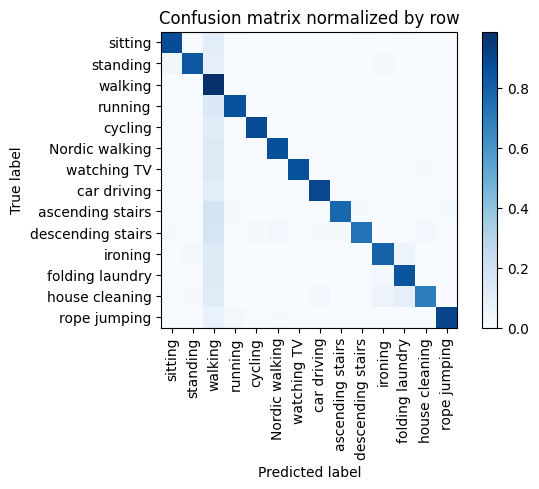

Training Epoch:  90%|█████████ | 9/10 [02:08<00:16, 16.81s/it]

Overall accuracy: 0.843



seen: 100%|██████████| 121/121 [00:02<00:00, 46.16batch/s, loss=0.308]


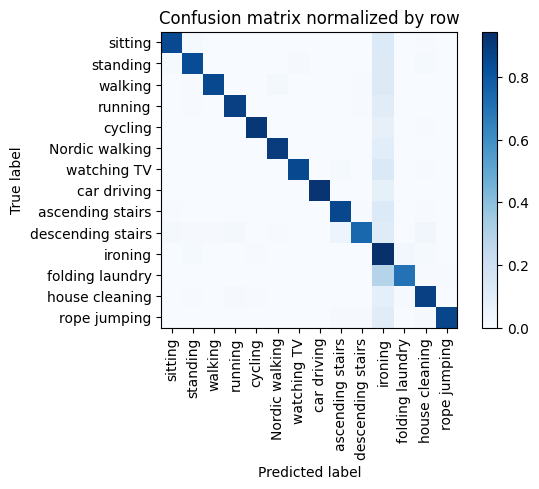

Overall accuracy: 0.865



unseen: 100%|██████████| 222/222 [00:03<00:00, 63.52batch/s, loss=12]  


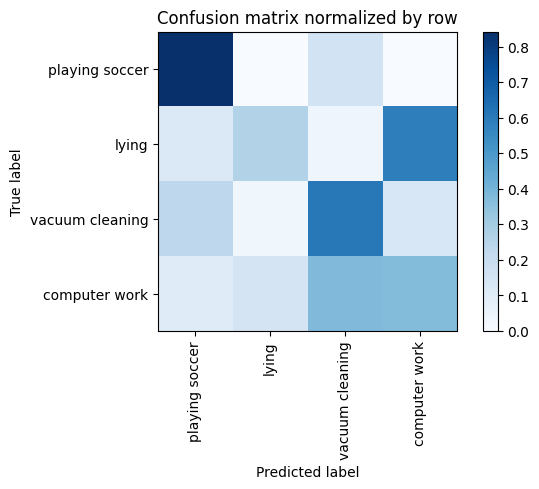

Overall accuracy: 0.429

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.463      0.371      0.412      0.432       3066|	 vacuum cleaning: 0.378,	lying: 0.151,	
          lying       0.486      0.261      0.340      0.264       1875|	 computer work: 0.586,	playing soccer: 0.115,	
vacuum cleaning       0.443      0.607      0.513      0.240       1706|	 playing soccer: 0.231,	computer work: 0.130,	
 playing soccer       0.296      0.842      0.438      0.064        457|	 vacuum cleaning: 0.158,	computer work: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.453      0.429      0.419        1.0       7104|	      

{'total_accuracy': 0.42905405405405406, 'precision': 0.4219685956554028, 'recall': 0.5204735126803387, 'f1': 0.42548703655686476}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking'

seen: 100%|██████████| 138/138 [00:02<00:00, 46.27batch/s, loss=0.619]


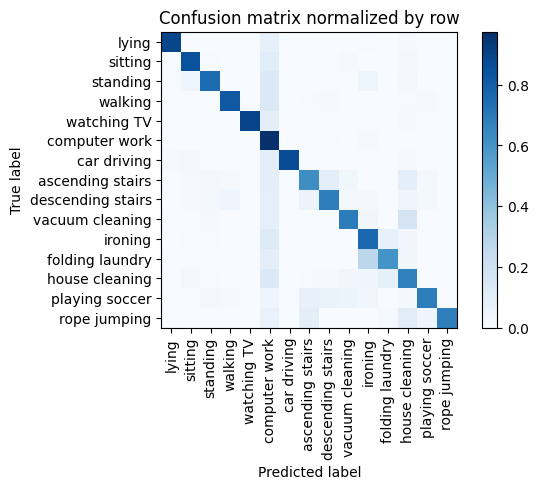

Training Epoch:  10%|█         | 1/10 [00:22<03:25, 22.78s/it]

Overall accuracy: 0.788



seen: 100%|██████████| 138/138 [00:03<00:00, 40.61batch/s, loss=0.598]


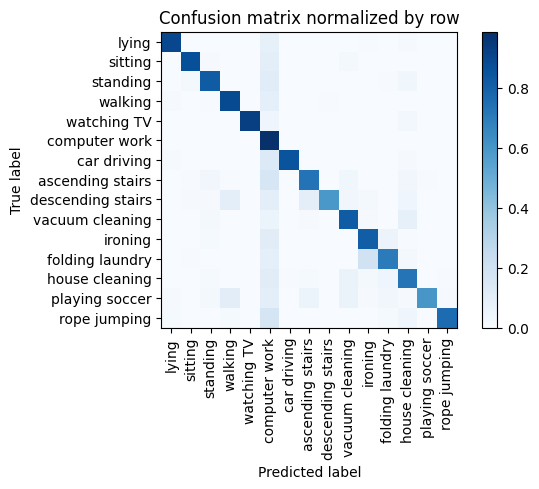

Training Epoch:  20%|██        | 2/10 [00:52<03:34, 26.84s/it]

Overall accuracy: 0.833



seen: 100%|██████████| 138/138 [00:03<00:00, 40.97batch/s, loss=0.305]


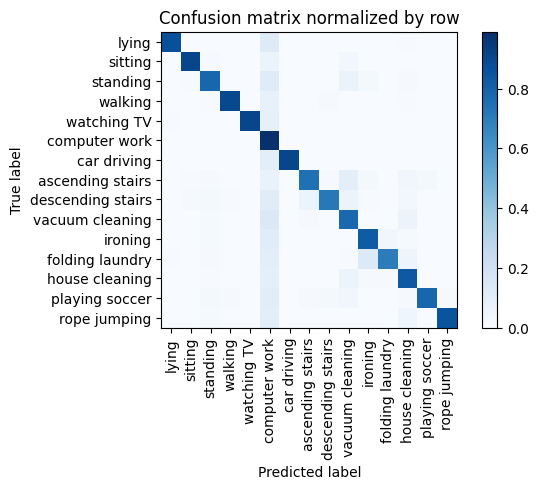

Training Epoch:  30%|███       | 3/10 [01:16<03:00, 25.75s/it]

Overall accuracy: 0.850



seen: 100%|██████████| 138/138 [00:03<00:00, 44.62batch/s, loss=0.262]


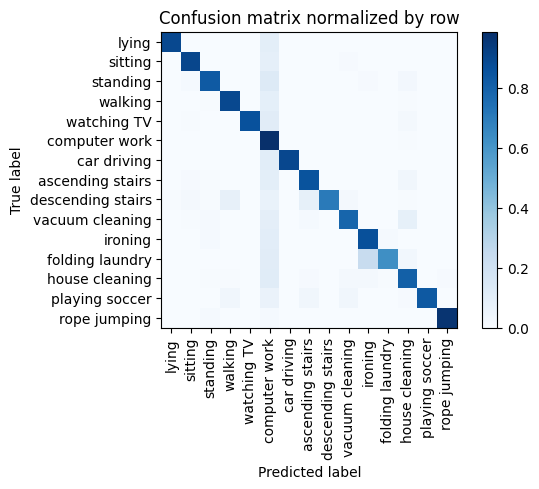

Training Epoch:  40%|████      | 4/10 [01:36<02:20, 23.44s/it]

Overall accuracy: 0.861



seen: 100%|██████████| 138/138 [00:03<00:00, 44.50batch/s, loss=0.683]


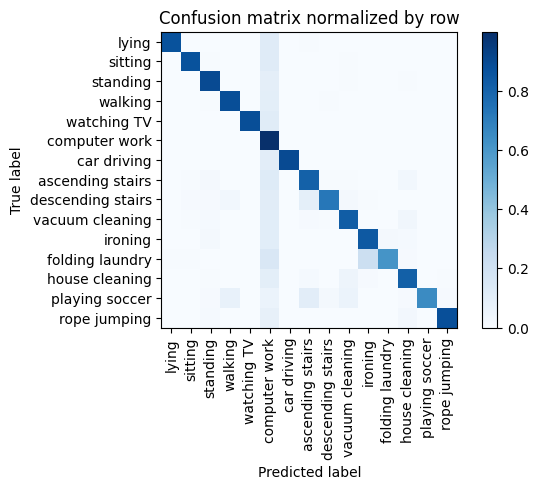

Training Epoch:  50%|█████     | 5/10 [01:57<01:52, 22.46s/it]

Overall accuracy: 0.856



seen: 100%|██████████| 138/138 [00:02<00:00, 51.14batch/s, loss=0.476]


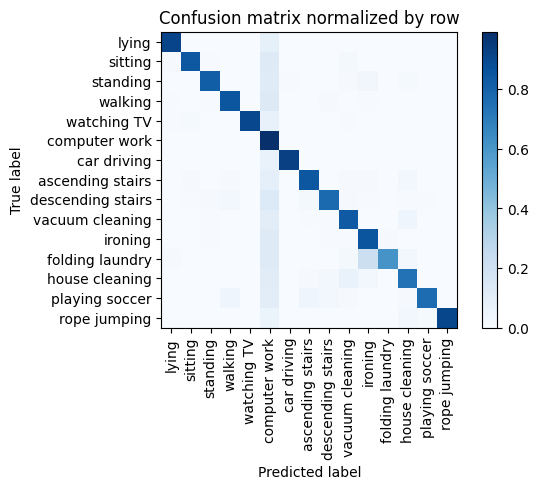

Training Epoch:  60%|██████    | 6/10 [02:18<01:28, 22.04s/it]

Overall accuracy: 0.849



seen: 100%|██████████| 138/138 [00:03<00:00, 44.30batch/s, loss=0.646]


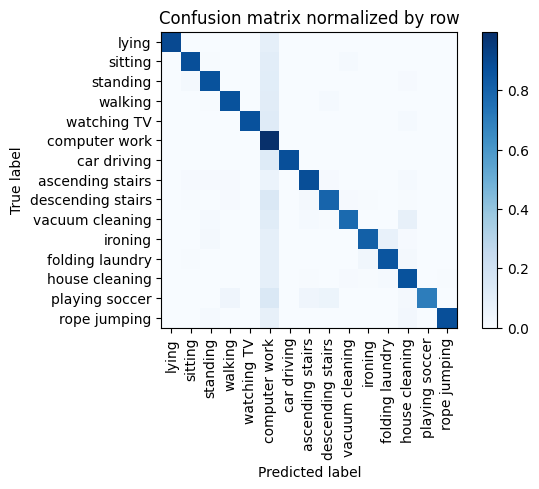

Training Epoch:  70%|███████   | 7/10 [02:38<01:03, 21.25s/it]

Overall accuracy: 0.869



seen: 100%|██████████| 138/138 [00:03<00:00, 41.70batch/s, loss=0.271]


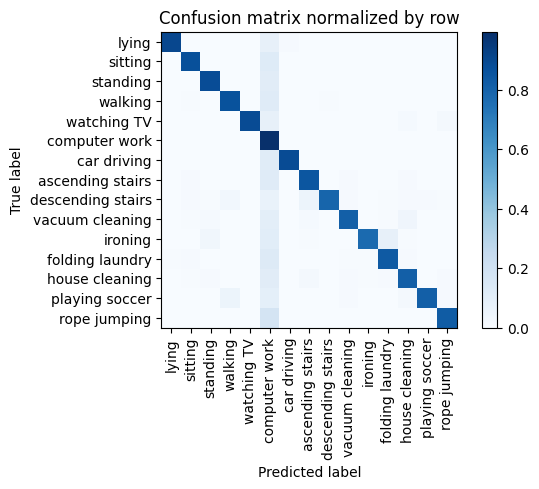

Training Epoch:  80%|████████  | 8/10 [02:59<00:42, 21.14s/it]

Overall accuracy: 0.865



seen: 100%|██████████| 138/138 [00:02<00:00, 51.23batch/s, loss=0.461]


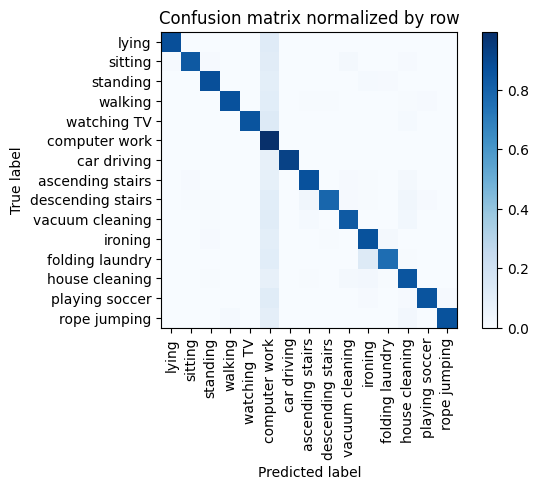

Training Epoch:  90%|█████████ | 9/10 [03:18<00:20, 20.44s/it]

Overall accuracy: 0.873



seen: 100%|██████████| 138/138 [00:02<00:00, 48.43batch/s, loss=0.49]


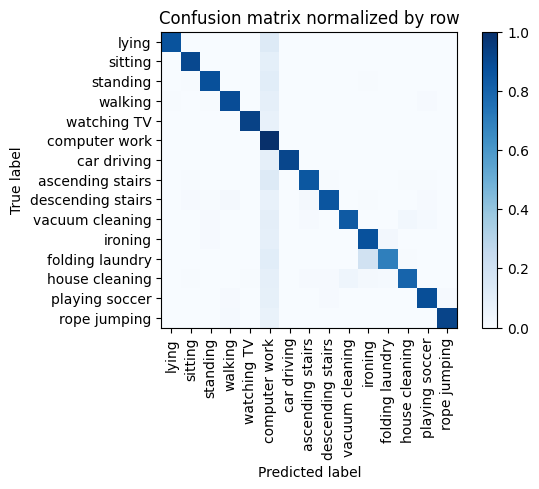

Overall accuracy: 0.880



unseen: 100%|██████████| 137/137 [00:02<00:00, 61.42batch/s, loss=13.7]


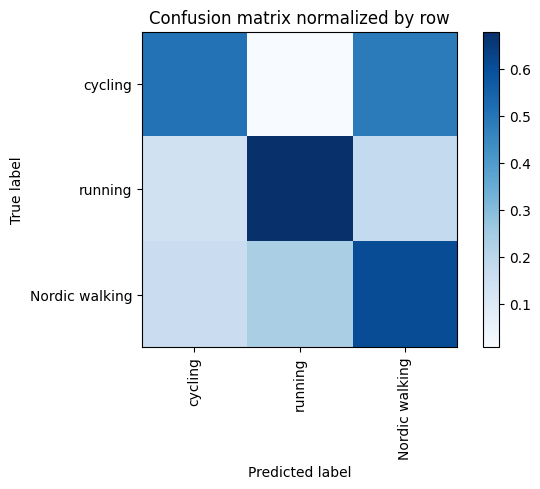

Overall accuracy: 0.584

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.540      0.603      0.570      0.419       1837|	 running: 0.236,	cycling: 0.161,	
       cycling       0.654      0.507      0.571      0.365       1600|	 Nordic walking: 0.484,	running: 0.009,	
       running       0.589      0.679      0.631      0.216        947|	 Nordic walking: 0.181,	cycling: 0.140,	

----------------------------------------------------------------------------------------------------
   avg / total       0.592      0.584      0.583        1.0       4384|	      

{'total_accuracy': 0.5843978102189781, 'precision': 0.5943659378970033, 'recall': 0.5963395313864926, 'f1': 0.590601121742992}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


seen: 100%|██████████| 141/141 [00:04<00:00, 30.26batch/s, loss=0.804]


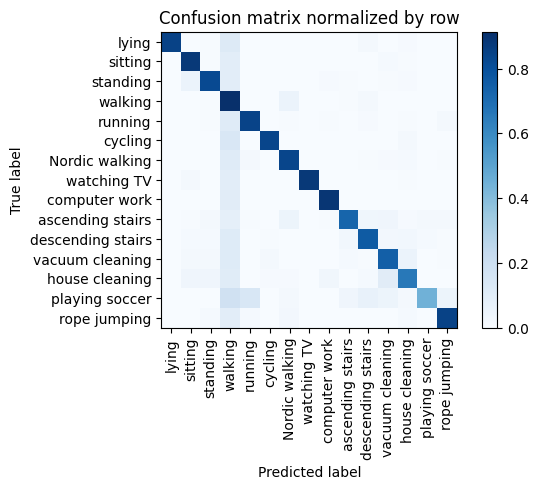

Training Epoch:  10%|█         | 1/10 [00:26<04:02, 26.89s/it]

Overall accuracy: 0.818



seen: 100%|██████████| 141/141 [00:05<00:00, 27.72batch/s, loss=0.608]


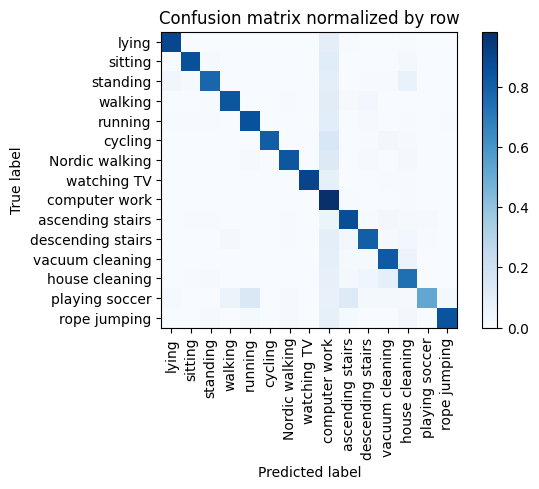

Training Epoch:  20%|██        | 2/10 [00:55<03:42, 27.86s/it]

Overall accuracy: 0.843



seen: 100%|██████████| 141/141 [00:04<00:00, 34.71batch/s, loss=0.404]


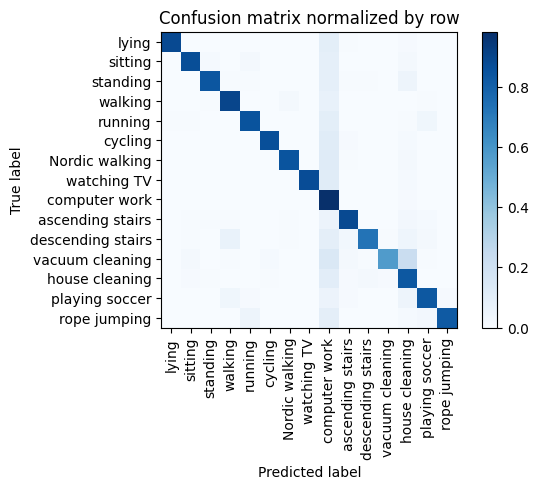

Training Epoch:  30%|███       | 3/10 [01:22<03:11, 27.31s/it]

Overall accuracy: 0.851



seen: 100%|██████████| 141/141 [00:03<00:00, 44.81batch/s, loss=0.338]


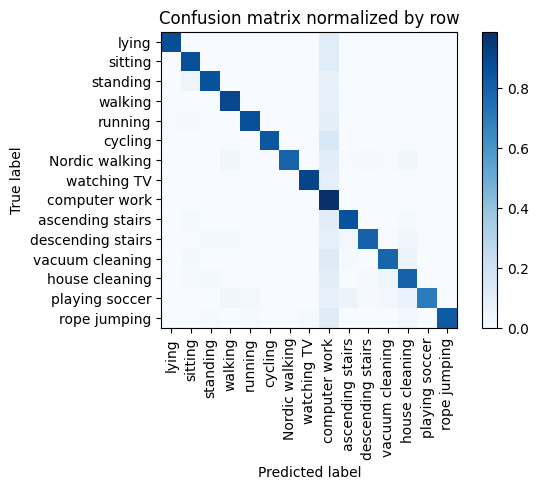

Training Epoch:  40%|████      | 4/10 [01:45<02:34, 25.81s/it]

Overall accuracy: 0.860



seen: 100%|██████████| 141/141 [00:04<00:00, 28.63batch/s, loss=0.463]


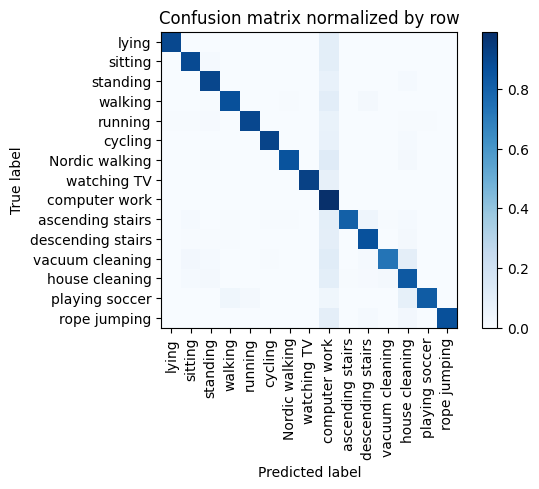

Training Epoch:  50%|█████     | 5/10 [02:12<02:10, 26.07s/it]

Overall accuracy: 0.881



seen: 100%|██████████| 141/141 [00:03<00:00, 39.88batch/s, loss=0.536]


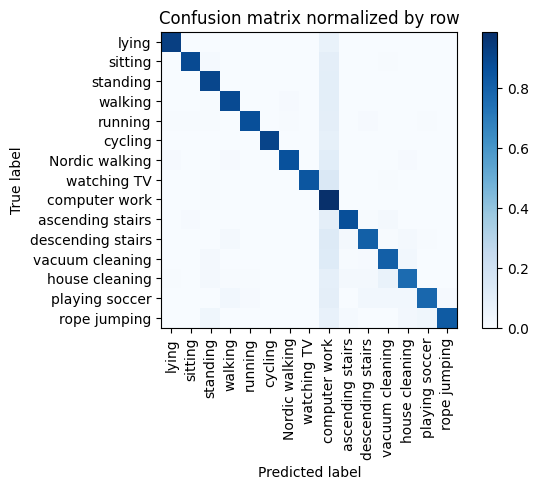

Training Epoch:  60%|██████    | 6/10 [02:35<01:40, 25.18s/it]

Overall accuracy: 0.877



seen: 100%|██████████| 141/141 [00:03<00:00, 40.29batch/s, loss=0.157]


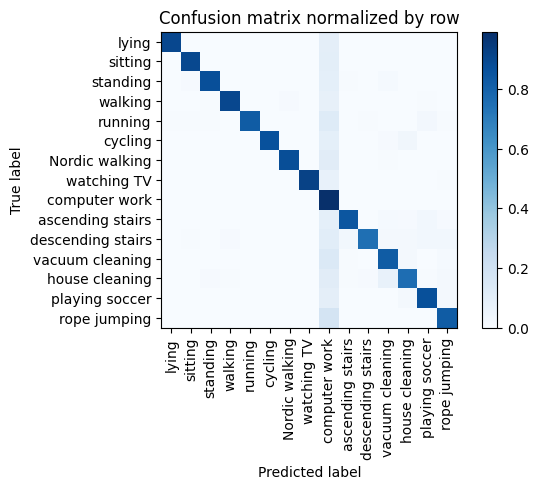

Training Epoch:  70%|███████   | 7/10 [03:00<01:15, 25.19s/it]

Overall accuracy: 0.875



seen: 100%|██████████| 141/141 [00:02<00:00, 47.51batch/s, loss=0.317]


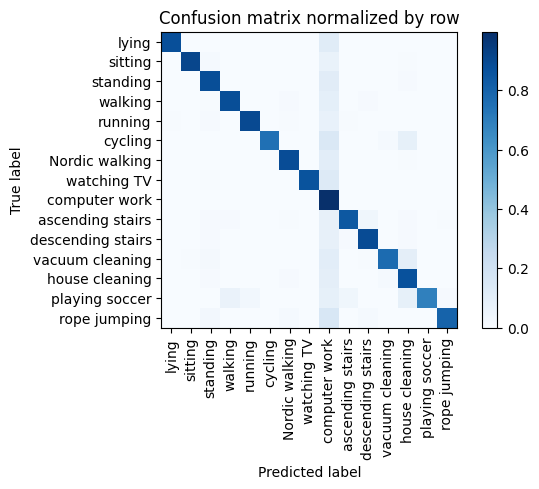

Training Epoch:  80%|████████  | 8/10 [03:26<00:50, 25.29s/it]

Overall accuracy: 0.872



seen: 100%|██████████| 141/141 [00:03<00:00, 43.37batch/s, loss=0.275]


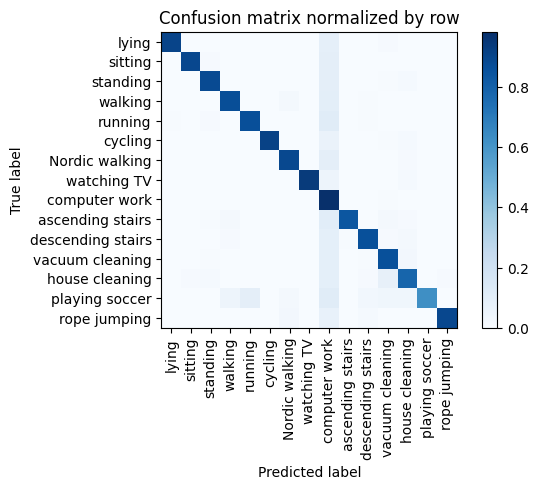

Training Epoch:  90%|█████████ | 9/10 [03:48<00:24, 24.40s/it]

Overall accuracy: 0.885



seen: 100%|██████████| 141/141 [00:03<00:00, 43.98batch/s, loss=0.415]


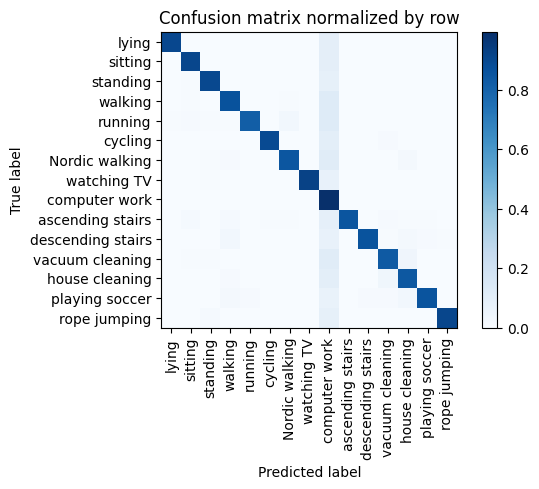

Overall accuracy: 0.888



unseen: 100%|██████████| 120/120 [00:02<00:00, 45.60batch/s, loss=11.5]


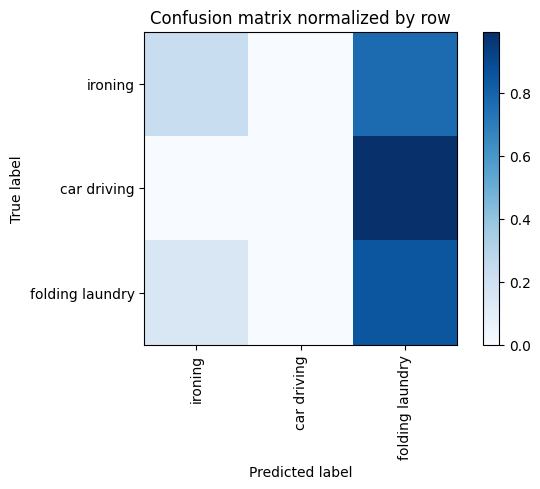

Overall accuracy: 0.356

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.785      0.232      0.358      0.607       2331|	 folding laundry: 0.767,	car driving: 0.001,	
folding laundry       0.263      0.850      0.401      0.253        973|	 ironing: 0.150,	car driving: 0.000,	
    car driving       0.000      0.000      0.000      0.140        536|	 folding laundry: 0.996,	ironing: 0.004,	

----------------------------------------------------------------------------------------------------
    avg / total       0.543      0.356      0.319        1.0       3840|	      

{'total_accuracy': 0.35598958333333336, 'precision': 0.3491411344899717, 'recall': 0.36053628139959076, 'f1': 0.2529661833156227}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.488795
precision         0.481356
recall            0.509625
f1                0.445531
dtype: float64

In [16]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    # data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20, normalize=False, smoothing=True)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    if dt == 'UTD':
        train_n = len(data_dict['train']['X'])
        seq_len, in_ft = 100, 6
    else:
        train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = dts(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt 
    eval_dt = dts(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = dts(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len, n_classes=len(seen_classes))
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'class': nn.CrossEntropyLoss(), 'feature': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step1(model, train_dl, optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.8)
        eval_metrics = eval_step1(model, eval_dl, loss_module, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='seen', print_report=False, loss_alpha=0.8)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(model, test_dl, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='unseen', loss_alpha=0.8)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    